In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/Sneaker Annotated Dataset.zip"

Archive:  /content/drive/My Drive/Sneaker Annotated Dataset.zip
   creating: Sneaker Annotated Dataset/black/
  inflating: Sneaker Annotated Dataset/black/0.png  
  inflating: Sneaker Annotated Dataset/black/102.png  
  inflating: Sneaker Annotated Dataset/black/105.png  
  inflating: Sneaker Annotated Dataset/black/107.png  
  inflating: Sneaker Annotated Dataset/black/112.png  
  inflating: Sneaker Annotated Dataset/black/113.png  
  inflating: Sneaker Annotated Dataset/black/116.png  
  inflating: Sneaker Annotated Dataset/black/125.png  
  inflating: Sneaker Annotated Dataset/black/126.png  
  inflating: Sneaker Annotated Dataset/black/131.png  
  inflating: Sneaker Annotated Dataset/black/144.png  
  inflating: Sneaker Annotated Dataset/black/147.png  
  inflating: Sneaker Annotated Dataset/black/152.png  
  inflating: Sneaker Annotated Dataset/black/160.png  
  inflating: Sneaker Annotated Dataset/black/166.png  
  inflating: Sneaker Annotated Dataset/black/170.png  
  inflating:

In [3]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from numpy import transpose, array
import torchvision.transforms.functional as TF

In [4]:
# Parameters
z_dim = 100
img_dim = 256
num_classes = 5
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
weight_decay = 1e-5
num_epochs = 300

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, img_dim*img_dim)

        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=3+1, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),

            # Shape here - 16*16*512

            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=16, stride=1, padding=0),
            # nn.Sigmoid()
        )

    def forward(self, x, label):
        label_embed = self.label_embedding(label)
        label_embed = label_embed.view(-1, 1, img_dim, img_dim)
        x = torch.cat((x, label_embed), dim=1)

        return self.disc(x)

class Generator(nn.Module):
    def __init__(self, label_embed_size=10):
        super().__init__()

        self.label_embedding = nn.Embedding(num_classes, label_embed_size)

        self.gen = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim+label_embed_size, out_channels=512, kernel_size=16, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x, label):
        label_embed = self.label_embedding(label)
        label_embed= label_embed.view(label_embed.shape[0], -1, 1, 1) # (batch_size, z_dim, 1, 1), concat along dim=1
        x = torch.cat((x, label_embed), dim=1)

        return self.gen(x)

In [6]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02) # normal distribution with mean 0 and std dev 0.02

def plot_generated_images():
    noise = torch.randn(25, z_dim, 1, 1).to(device)
    labels = torch.randint(0, num_classes, (25,), device=device)
    print(labels)
    fake = gen(noise, labels)

    # Convert tensor to PIL images and renormalize
    fake_images = [(TF.to_pil_image((img * 0.5) + 0.5)) for img in fake]

    # Plot the images
    for i in range(25):
      plt.subplot(5, 5, 1 + i)
      plt.axis('off')

      plt.imshow(fake_images[i])

    plt.savefig(f"/content/drive/My Drive/Sneaker cGAN/results_{epoch+1}.png")
    plt.show()

Folder loaded
Training started
Epoch [1/300] Loss D: 0.0005 Loss G: 32.1565
Epoch [2/300] Loss D: 0.0005 Loss G: 27.3509
Epoch [3/300] Loss D: 0.0025 Loss G: 23.8256
Epoch [4/300] Loss D: 0.0001 Loss G: 18.2921
Epoch [5/300] Loss D: 0.0109 Loss G: 9.7910
Epoch [6/300] Loss D: 0.0003 Loss G: 94.9610
Epoch [7/300] Loss D: 0.0029 Loss G: 26.5316
Epoch [8/300] Loss D: 0.0002 Loss G: 19.3039
Epoch [9/300] Loss D: 0.0400 Loss G: 48.6280
Epoch [10/300] Loss D: 0.0052 Loss G: 59.2975
Epoch [11/300] Loss D: 0.0724 Loss G: 20.8648
Epoch [12/300] Loss D: 0.0014 Loss G: 14.7320
Epoch [13/300] Loss D: 0.0002 Loss G: 13.8618
Epoch [14/300] Loss D: 0.0000 Loss G: 66.6176
Epoch [15/300] Loss D: 0.0119 Loss G: 12.1612
Epoch [16/300] Loss D: 0.0050 Loss G: 12.8670
Epoch [17/300] Loss D: 0.1782 Loss G: 22.2657
Epoch [18/300] Loss D: 0.1486 Loss G: 13.0794
Epoch [19/300] Loss D: 0.1472 Loss G: 11.5167
Epoch [20/300] Loss D: 6.3134 Loss G: 19.8698
Epoch [21/300] Loss D: 0.0818 Loss G: 11.3320
Epoch [22/300

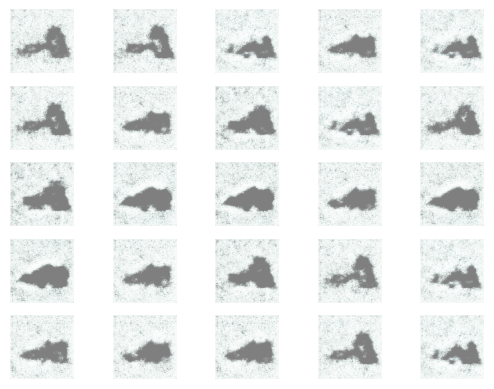

Epoch [51/300] Loss D: 0.0022 Loss G: 15.8547
Epoch [52/300] Loss D: 0.0020 Loss G: 10.7390
Epoch [53/300] Loss D: 0.0035 Loss G: 9.7090
Epoch [54/300] Loss D: 0.0033 Loss G: 9.5002
Epoch [55/300] Loss D: 0.0216 Loss G: 6.3350
Epoch [56/300] Loss D: 0.0001 Loss G: 11.6835
Epoch [57/300] Loss D: 0.0006 Loss G: 9.4817
Epoch [58/300] Loss D: 0.0006 Loss G: 8.2808
Epoch [59/300] Loss D: 0.0026 Loss G: 8.1170
Epoch [60/300] Loss D: 0.0001 Loss G: 9.2452
Epoch [61/300] Loss D: 0.0021 Loss G: 13.9712
Epoch [62/300] Loss D: 0.0042 Loss G: 14.5405
Epoch [63/300] Loss D: 0.0024 Loss G: 10.6772
Epoch [64/300] Loss D: 0.0012 Loss G: 8.1441
Epoch [65/300] Loss D: 0.0094 Loss G: 11.7347
Epoch [66/300] Loss D: 2.3752 Loss G: 5.4526
Epoch [67/300] Loss D: 0.1057 Loss G: 18.0696
Epoch [68/300] Loss D: 0.0161 Loss G: 10.7822
Epoch [69/300] Loss D: 0.0015 Loss G: 9.6266
Epoch [70/300] Loss D: 0.0013 Loss G: 8.9570
Epoch [71/300] Loss D: 0.0243 Loss G: 7.9408
Epoch [72/300] Loss D: 0.0015 Loss G: 8.4681
E

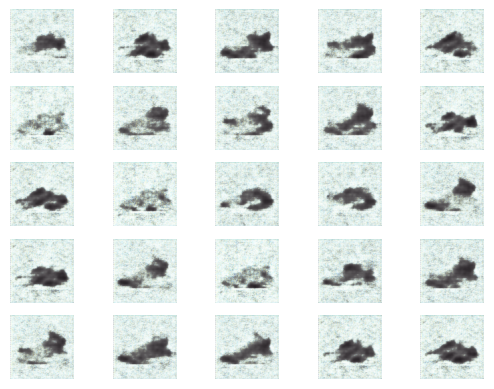

Epoch [101/300] Loss D: 1.1086 Loss G: 35.1301
Epoch [102/300] Loss D: 0.5406 Loss G: 9.3237
Epoch [103/300] Loss D: 0.4293 Loss G: 17.9742
Epoch [104/300] Loss D: 0.1917 Loss G: 16.8904
Epoch [105/300] Loss D: 14.4571 Loss G: 1.1459
Epoch [106/300] Loss D: 0.4287 Loss G: 1.4390
Epoch [107/300] Loss D: 1.3397 Loss G: 28.6783
Epoch [108/300] Loss D: 0.1815 Loss G: 5.0727
Epoch [109/300] Loss D: 0.3855 Loss G: 13.3812
Epoch [110/300] Loss D: 0.8592 Loss G: 16.1547
Epoch [111/300] Loss D: 0.2884 Loss G: 11.8679
Epoch [112/300] Loss D: 0.2183 Loss G: 4.4999
Epoch [113/300] Loss D: 0.5644 Loss G: 4.9049
Epoch [114/300] Loss D: 0.3492 Loss G: 4.2959
Epoch [115/300] Loss D: 0.1389 Loss G: 5.1964
Epoch [116/300] Loss D: 0.6381 Loss G: 2.8129
Epoch [117/300] Loss D: 0.3009 Loss G: 9.0500
Epoch [118/300] Loss D: 0.2345 Loss G: 8.8271
Epoch [119/300] Loss D: 0.2260 Loss G: 9.1579
Epoch [120/300] Loss D: 0.0921 Loss G: 6.3136
Epoch [121/300] Loss D: 0.5684 Loss G: 13.5205
Epoch [122/300] Loss D: 1

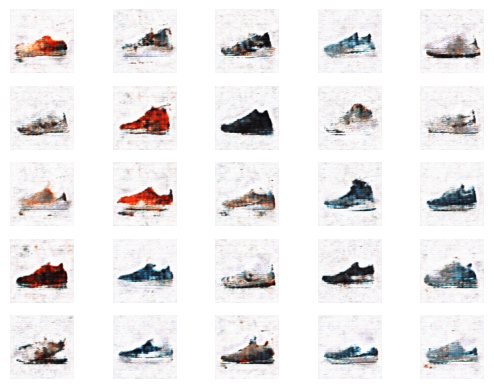

Epoch [151/300] Loss D: 1.1596 Loss G: 7.6997
Epoch [152/300] Loss D: 1.3475 Loss G: 12.0407
Epoch [153/300] Loss D: 1.5252 Loss G: 10.5380
Epoch [154/300] Loss D: 0.8036 Loss G: 8.7445
Epoch [155/300] Loss D: 0.8057 Loss G: 1.0275
Epoch [156/300] Loss D: 0.7066 Loss G: 7.7074
Epoch [157/300] Loss D: 2.5540 Loss G: 2.0267
Epoch [158/300] Loss D: 1.0781 Loss G: 2.3864
Epoch [159/300] Loss D: 0.7130 Loss G: 7.0387
Epoch [160/300] Loss D: 1.2692 Loss G: 1.4903
Epoch [161/300] Loss D: 1.0424 Loss G: 8.1171
Epoch [162/300] Loss D: 0.3428 Loss G: 4.1104
Epoch [163/300] Loss D: 1.3338 Loss G: 7.1251
Epoch [164/300] Loss D: 0.6016 Loss G: 5.8582
Epoch [165/300] Loss D: 0.8116 Loss G: 5.8854
Epoch [166/300] Loss D: 0.5248 Loss G: 3.5166
Epoch [167/300] Loss D: 0.7130 Loss G: 0.6339
Epoch [168/300] Loss D: 1.1510 Loss G: 7.8363
Epoch [169/300] Loss D: 0.5791 Loss G: 1.5524
Epoch [170/300] Loss D: 0.8036 Loss G: 5.9124
Epoch [171/300] Loss D: 1.1603 Loss G: 0.2049
Epoch [172/300] Loss D: 0.6740 L

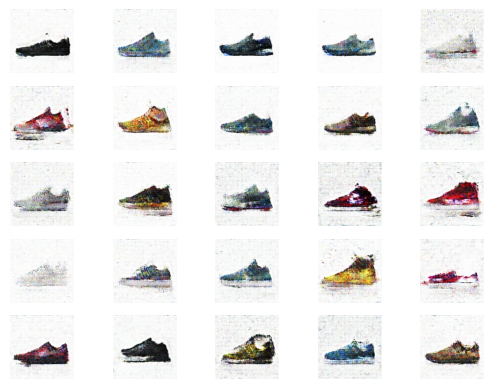

Epoch [201/300] Loss D: 0.8435 Loss G: 5.5377
Epoch [202/300] Loss D: 0.8382 Loss G: 0.8877
Epoch [203/300] Loss D: 0.8495 Loss G: 5.7860
Epoch [204/300] Loss D: 1.1186 Loss G: 1.7916
Epoch [205/300] Loss D: 0.9641 Loss G: 0.8578
Epoch [206/300] Loss D: 0.9749 Loss G: 5.1473
Epoch [207/300] Loss D: 0.8330 Loss G: 1.3120
Epoch [208/300] Loss D: 0.5685 Loss G: 5.1093
Epoch [209/300] Loss D: 0.9292 Loss G: 0.5867
Epoch [210/300] Loss D: 0.6339 Loss G: 5.0178
Epoch [211/300] Loss D: 0.9510 Loss G: 0.4223
Epoch [212/300] Loss D: 0.7065 Loss G: 4.6416
Epoch [213/300] Loss D: 0.4553 Loss G: 4.1920
Epoch [214/300] Loss D: 1.0590 Loss G: 0.9306
Epoch [215/300] Loss D: 0.6312 Loss G: 4.8318
Epoch [216/300] Loss D: 0.6133 Loss G: 0.9425
Epoch [217/300] Loss D: 0.4355 Loss G: 4.4343
Epoch [218/300] Loss D: 0.5031 Loss G: 1.3337
Epoch [219/300] Loss D: 0.3767 Loss G: 3.1051
Epoch [220/300] Loss D: 0.3205 Loss G: 3.4281
Epoch [221/300] Loss D: 0.7724 Loss G: 0.5891
Epoch [222/300] Loss D: 0.5597 Los

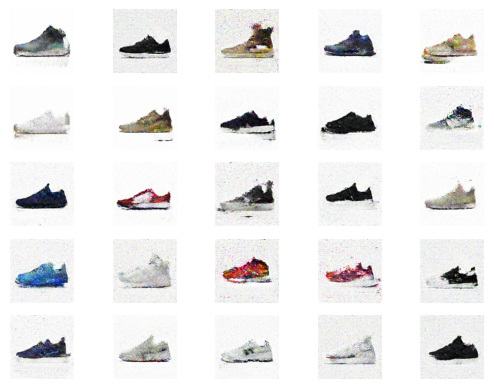

Epoch [251/300] Loss D: 0.5861 Loss G: 5.3437
Epoch [252/300] Loss D: 0.5814 Loss G: 1.4886
Epoch [253/300] Loss D: 0.7644 Loss G: 6.1637
Epoch [254/300] Loss D: 0.6345 Loss G: 1.3540
Epoch [255/300] Loss D: 0.6820 Loss G: 5.4570
Epoch [256/300] Loss D: 0.8012 Loss G: 5.9752
Epoch [257/300] Loss D: 0.8965 Loss G: 0.8531
Epoch [258/300] Loss D: 0.2968 Loss G: 2.6606
Epoch [259/300] Loss D: 0.4534 Loss G: 4.7099
Epoch [260/300] Loss D: 0.6233 Loss G: 1.9609
Epoch [261/300] Loss D: 0.5764 Loss G: 5.5470
Epoch [262/300] Loss D: 0.5753 Loss G: 1.3435
Epoch [263/300] Loss D: 0.5832 Loss G: 6.1693
Epoch [264/300] Loss D: 0.4293 Loss G: 1.3457
Epoch [265/300] Loss D: 0.4969 Loss G: 5.3855
Epoch [266/300] Loss D: 0.4963 Loss G: 1.9222
Epoch [267/300] Loss D: 0.6148 Loss G: 5.3872
Epoch [268/300] Loss D: 0.5071 Loss G: 1.2090
Epoch [269/300] Loss D: 0.5702 Loss G: 4.1103
Epoch [270/300] Loss D: 0.4187 Loss G: 3.9695
Epoch [271/300] Loss D: 0.5725 Loss G: 2.1355
Epoch [272/300] Loss D: 0.3971 Los

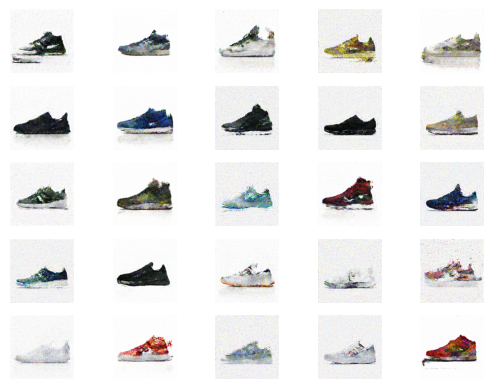

In [7]:
transform = tfs.Compose(
    [
        tfs.Resize(img_dim),
        tfs.ToTensor(),
        tfs.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        # mean and std of 0.5 normalizes between [-1, 1]. applied to all 3 channels
    ]
)

# Load dataset
dataset = ImageFolder(root="/content/Sneaker Annotated Dataset", transform=transform)
loader = DataLoader(dataset, batch_size=256, shuffle=True)
print("Folder loaded")

# Initialize gen and disc
gen = Generator(label_embed_size=10).to(device)
disc = Discriminator().to(device)
initialize_weights(gen)
initialize_weights(disc)

# Initialize optimizer
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)

# Loss functions
loss_fn = nn.BCEWithLogitsLoss() # combination of sigmoid and BCE loss, more numerically stable

gen.train()
disc.train()

print("Training started")

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader):
        real = images.to(device)
        batch_size = real.size(0)

        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise, labels.to(device))

        disc_real = disc(real.detach(), labels.to(device))
        disc_fake = disc(fake.detach(), labels.to(device))
        disc_loss = (loss_fn(disc_real, torch.ones_like(disc_real)) + loss_fn(disc_fake, torch.zeros_like(disc_fake))) / 2

        disc_opt.zero_grad()
        disc_loss.backward()
        disc_opt.step()

        disc_fake = disc(fake, labels.to(device))
        gen_loss = loss_fn(disc_fake, torch.ones_like(disc_fake))

        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {disc_loss:.4f} Loss G: {gen_loss:.4f}")

    if (epoch + 1) % 50 == 0:
        plot_generated_images()
        torch.save(gen, f"/content/drive/My Drive/Sneaker cGAN/model_{epoch+1}.pt")
